# Project Description

# Setup

In [1]:
# Data
import pandas as pd
import numpy as np

# Plots
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

# Technical
import time
import os
import typing

In [2]:
data = pd.read_csv(r"Walmart_Store_sales.csv")
display(data.head())
print(f"Amount of rows:{data.shape[0]}")

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


Amount of rows:150


# EDA

In [3]:
data.describe(include='all')

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


In [4]:
px.scatter_matrix(data.drop('Holiday_Flag', axis=1).sort_values(by='Date'),
                  width=800, height=800)

<Axes: >

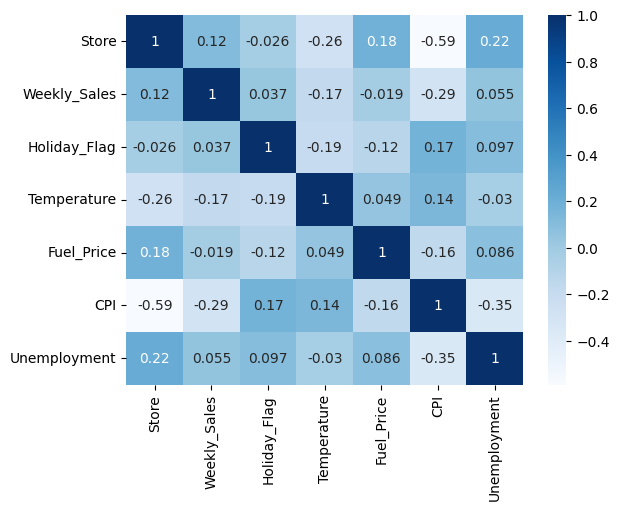

In [5]:
corr = data.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap=plt.cm.Blues)

In [6]:
corr['Weekly_Sales'].sort_values(key=abs, ascending=False).to_frame()

,Weekly_Sales
Weekly_Sales,1.000000
CPI,-0.287227
Temperature,-0.165991
Store,0.115964
Unemployment,0.055191
Holiday_Flag,0.037037
Fuel_Price,-0.019087


In [7]:
m = 10

for col in data.drop('Weekly_Sales', axis=1).columns:
    px.scatter(data, x=col, y='Weekly_Sales',
               width=600, height=300,).update_layout(margin=dict(l=m, r=m, t=m, b=m)).show()

# Cleaning

## Missing Data

In [8]:
# Look at percentage of missing data by column
round(data.isna().sum() / data.shape[0] * 100, 2)

Store            0.00
Date            12.00
Weekly_Sales     9.33
Holiday_Flag     8.00
Temperature     12.00
Fuel_Price       9.33
CPI              8.00
Unemployment    10.00
dtype: float64

In [9]:
# Prepare dataframe
data.rename(columns={key:str.lower(key) for key in data.columns}, inplace=True)
data.sort_values(by='date', inplace=True)
data.replace('nan', np.nan, inplace=True)

# Drop rows with missing date or target (cannot be imputed)
data = data.dropna(axis=0, subset=['date', 'weekly_sales'])

In [10]:
# Convert date col to datetime
data['date'] = pd.to_datetime(data['date'], format='mixed')

# Create imputed data DF with date
impute_data = pd.DataFrame()
impute_data['date'] = data['date']
impute_data = impute_data.sort_values(by='date')

# Impute Holiday_Flag using holiday library
import holidays
us_holidays = holidays.US()
impute_data['holiday_flag'] = impute_data['date'].apply(lambda x: 1 if x in us_holidays else 0)

# Impute Temperature using historical data over whole US
data_temperature = pd.read_csv(r"average_monthly_temperature_by_state_1950-2022.csv")
data_temperature = data_temperature[['month', 'year', 'average_temp']]
data_temperature['date'] = pd.to_datetime(dict(year=data_temperature['year'], month=data_temperature['month'], day=1))
data_temperature = data_temperature.groupby('date').mean().reset_index()
data_temperature = data_temperature.rename(columns={'average_temp' : 'temperature'})[['date', 'temperature']]
data_temperature.sort_values(by='date', inplace=True)
impute_data = pd.merge_asof(impute_data, data_temperature, on='date', direction='nearest')

# Impute Fuel Price using historical data
data_fuel = pd.read_csv(r"weekly_us_all_grade_all_formulations_retail_gasoline_price.csv")
data_fuel.rename(columns={
    'Week of' : 'date',
    'Weekly U.S. All Grades All Formulations Retail Gasoline Prices Dollars per Gallon' : 'fuel_price'
}, inplace=True)
data_fuel['date'] = pd.to_datetime(data_fuel['date'], format='mixed')
data_fuel.sort_values(by='date', inplace=True)
impute_data = pd.merge_asof(impute_data, data_fuel, on='date', direction='nearest')

# Impute CPI using historical data
data_cpi = pd.read_csv(r"cpi_data.csv")
data_cpi.rename(columns={'Date' : 'date', 'Index' : 'cpi'}, inplace=True)
data_cpi['date'] = pd.to_datetime(data_cpi['date'], format='mixed')
data_cpi = data_cpi.iloc[:,:2]
data_cpi = data_cpi.sort_values(by='date', inplace=True)
impute_data = pd.merge_asof(impute_data, data_cpi, on='date', direction='nearest')

# Impute Unemployment using historical data
data_unemployment = pd.read_csv(r"unemployment_data_us.csv")
data_unemployment.rename(columns={'Date' : 'date'}, inplace=True)
data_unemployment['date'] = pd.to_datetime(data_unemployment['date'], format='mixed')
data_unemployment = data_unemployment.drop(['Month'], axis=1)
data_unemployment = data_unemployment[['date', 'Men', 'Women']].groupby('date').mean().reset_index()
data_unemployment['unemployment'] = (data_unemployment['Men'] + data_unemployment['Women']) / 2
data_unemployment.drop(['Men', 'Women'], axis=1, inplace=True)
data_unemployment.sort_values(by='date', inplace=True)
impute_data = pd.merge_asof(impute_data, data_unemployment, on='date', direction='nearest')

# Combine this into final dataframe
impute_columns = ['holiday_flag', 'temperature', 'fuel_price', 'cpi', 'unemployment']

# Reset indices so the .fillna() works correctly
data.reset_index(inplace=True)
impute_data.reset_index(inplace=True)

# Flag whether NA data was imputed or not and fill NAs with imputed data
for col in impute_columns:
    data[f'{col}_was_missing'] = data[col].isna()
    data[col].fillna(impute_data[col], inplace=True)
    
data = data.drop('index', axis=1)

In [11]:
# Look at percentage of missing data
round(np.mean(data.isna().sum() / data.shape[0] * 100), 2)

0.0

## Outliers

In this project, will be considered as outliers all the numeric features that don't fall within the range : $[\bar{X} - 3\sigma, \bar{X} + 3\sigma]$

This concerns the columns : *Temperature*, *Fuel_price*, *CPI* and *Unemployment*

In [12]:
outlier_columns = ['temperature', 'fuel_price', 'cpi', 'unemployment']

# For each column mask by values that are > mu - 3std and < mu + 3 std
for col in outlier_columns:
    data = data[(data[col] < np.mean(data[col]) + np.std(data[col]) * 3) &\
        (data[col] > np.mean(data[col]) - np.std(data[col] * 3))]

## Date Conversion

In [13]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['dow'] = data['date'].dt.dayofweek

data.drop('date', axis=1, inplace=True)

In [15]:
data.to_csv(r"clean_data.csv")
data.head()

,store,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,holiday_flag_was_missing,temperature_was_missing,fuel_price_was_missing,cpi_was_missing,unemployment_was_missing,year,month,day,dow
0,13.0,2035431.39,0.0,61.11,3.788,130.959226,5.965,False,False,False,False,False,2012,1,6,4
1,17.0,829207.27,0.0,60.07,2.853,126.234600,6.885,False,False,False,False,False,2010,1,10,6
2,10.0,1990371.02,0.0,57.62,3.882,130.645793,7.545,False,False,False,False,False,2012,2,3,4
3,7.0,561145.14,0.0,38.26,2.725,189.704822,8.963,False,False,False,False,False,2010,2,4,3
4,19.0,1549018.68,0.0,66.25,2.958,132.521867,8.099,False,False,False,False,False,2010,2,7,6
